In [4]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2

In [30]:
import scanpy as sc
import pandas as pd
import json
import numpy as np
from PIL import Image
import os

def load_fresh_visium_with_annotations(sample_id='KC1'):
    """
    Load fresh Visium data from H5 files with spatial information and annotations
    """
    
    # Read the H5 file
    h5_path = f'/data/Datasets/Annotated/TLS_VISIUM/h5/{sample_id}_filtered_feature_bc_matrix.h5'
    adata = sc.read_10x_h5(h5_path, gex_only=True)
    adata.var_names_make_unique()
    
    print(f"Loaded count matrix: {adata.shape}")
    
    # Load spatial information
    spatial_dir = f'/data/Datasets/Annotated/TLS_VISIUM/10x_Visium/{sample_id}/spatial/'
    
    # Load tissue positions
    positions = pd.read_csv(
        os.path.join(spatial_dir, 'tissue_positions_list.csv'),
        index_col='barcode'
    )
    
    # Load scale factors
    with open(os.path.join(spatial_dir, 'scalefactors_json.json'), 'r') as f:
        scalefactors = json.load(f)
    
    # Set up spatial structure
    adata.uns['spatial'] = {}
    adata.uns['spatial'][sample_id] = {
        'images': {},
        'scalefactors': scalefactors,
        'metadata': {
            'chemistry_description': 'Visium_v1',
            'software_version': 'spaceranger'
        }
    }
    
    # Add spatial information to observations
    adata.obs = adata.obs.join(positions, how='left')
    
    # Add spatial coordinates
    adata.obsm['spatial'] = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values
    
    # Load images with correct key names
    img_path = os.path.join(spatial_dir, 'tissue_hires_image.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        adata.uns['spatial'][sample_id]['images']['hires'] = np.array(img)
    
    img_path = os.path.join(spatial_dir, 'tissue_lowres_image.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        adata.uns['spatial'][sample_id]['images']['lowres'] = np.array(img)
    
    # Load high-resolution TIF
    tif_path = f'/data/Datasets/Annotated/TLS_VISIUM/tif_slides/{sample_id}.tif'
    if os.path.exists(tif_path):
        tif_img = Image.open(tif_path)
        adata.uns['spatial'][sample_id]['images']['fullres'] = np.array(tif_img)
    
    # Filter to spots in tissue first
    adata = adata[adata.obs['in_tissue'] == 1].copy()
    print(f"Shape after filtering to in-tissue spots: {adata.shape}")

    # Add friendly aliases to obs
    required = {'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'}
    missing = required - set(adata.obs.columns)
    if missing:
        print(f"⚠️ Missing spatial columns in positions: {missing}")
    else:
        adata.obs['x_array'] = pd.to_numeric(adata.obs['array_col'], errors='coerce').astype('Int64')
        adata.obs['y_array'] = pd.to_numeric(adata.obs['array_row'], errors='coerce').astype('Int64')
        adata.obs['x_pixel'] = pd.to_numeric(adata.obs['pxl_col_in_fullres'], errors='coerce')
        adata.obs['y_pixel'] = pd.to_numeric(adata.obs['pxl_row_in_fullres'], errors='coerce')
    
    # Load your saved annotations
    annotation_path = f"/data/data/TLS_VISIUM_USZ/annotations/{sample_id}_annotation.csv"
    if os.path.exists(annotation_path):
        print(f"Loading annotations from {annotation_path}")
        annotations = pd.read_csv(annotation_path, index_col=0)
        
        # Get annotation columns (exclude spatial/technical columns)
        annotation_cols = ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 
                          'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']
        
        available_annotation_cols = [col for col in annotation_cols if col in annotations.columns]
        print(f"Found annotation columns: {available_annotation_cols}")
        
        # Add annotations to adata.obs
        for col in available_annotation_cols:
            # Match by barcode index
            matched_values = annotations.reindex(adata.obs.index)[col]
            adata.obs[col] = matched_values
            non_null_count = sum(~matched_values.isna())
            print(f"  {col}: {non_null_count} spots annotated")
    else:
        print(f"No annotation file found at {annotation_path}")
    
    print(f"Final shape: {adata.shape}")
    print(f"Available images: {list(adata.uns['spatial'][sample_id]['images'].keys())}")
    print(f"Annotation columns: {[col for col in adata.obs.columns if 'manual' in col or col in ['ground_truth', 'blur_score']]}")
    
    return adata

Loaded count matrix: (4364, 17845)
Shape after filtering to in-tissue spots: (4364, 17845)
Loading annotations from /data/data/TLS_VISIUM_USZ/annotations/LC1_annotation.csv
Found annotation columns: ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']
  manual_anno: 4361 spots annotated
  manual_anno_tls: 4361 spots annotated
  aestetik_manual_anno: 4361 spots annotated
  aestetik_manual_anno_tls: 4361 spots annotated
  ground_truth: 4361 spots annotated
  blur_score: 4361 spots annotated
Final shape: (4364, 17845)
Available images: ['hires', 'lowres', 'fullres']
Annotation columns: ['manual_anno', 'manual_anno_tls', 'aestetik_manual_anno', 'aestetik_manual_anno_tls', 'ground_truth', 'blur_score']


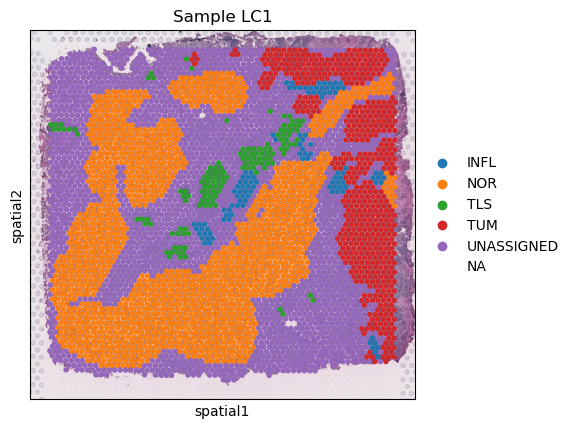

In [31]:
# Load a sample with annotations
adata = load_fresh_visium_with_annotations('LC1')

# Quick visualization
sample_id = list(adata.uns['spatial'].keys())[0]
sc.pl.spatial(adata, img_key='hires', color='manual_anno', size=1.5, title=f"Sample {sample_id}")

In [84]:
#Read original data and save it to h5ad
from scanpy import read_10x_h5
adata = read_10x_h5("/data/Datasets/Annotated/TLS_VISIUM/h5/LC1_filtered_feature_bc_matrix.h5")
spatial=pd.read_csv("Datasets/Annotated/TLS_VISIUM/10x_Visium/LC1/spatial/tissue_positions_list.csv",sep=",",skiprows=1,header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]

In [85]:
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("Datasets/kate/LC1.h5ad")

In [86]:
img=cv2.imread("Datasets/Annotated/TLS_VISIUM/10x_Visium/LC1/spatial/tissue_hires_image.png")

In [87]:
scale=float( pd.read_json(f'Datasets/Annotated/TLS_VISIUM/10x_Visium/LC1/spatial/scalefactors_json.json',orient='index').loc['tissue_hires_scalef'] )
x_pixel_new=np.array(adata.obs['x_pixel'] * scale).astype(int)
y_pixel_new=np.array(adata.obs['y_pixel'] * scale).astype(int)

In [88]:
#Set coordinates
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=x_pixel_new.tolist()
y_pixel=y_pixel_new.tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20*scale):int(x+20*scale), int(y-20*scale):int(y+20*scale),:]=0

cv2.imwrite('Datasets/kate/map.jpg', img_new)

True

In [89]:
#Calculate adjacent matrix
s=1
b=49*scale
adj=spg.calculate_adj_matrix(x=x_array,y=y_array, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('Datasets/kate/spagcn_adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  131.931629585021 274.08531649416153 298.7282250215284
Var of x,y,z =  389.2219337282541 1341.3895695638257 1341.3895695638253


In [90]:
adj=np.loadtxt('Datasets/kate/spagcn_adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [91]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 4349.630045782366]
Run 2: l [0.01, 500.005], p [0.0, 4309.951871210853]
Run 3: l [0.01, 250.0075], p [0.0, 4157.448016406465]
Run 4: l [0.01, 125.00874999999999], p [0.0, 3632.7616464592156]
Run 5: l [0.01, 62.509375], p [0.0, 2357.7991550506626]
Run 6: l [0.01, 31.2596875], p [0.0, 877.4360609158404]
Run 7: l [0.01, 15.63484375], p [0.0, 191.7774397444531]
Run 8: l [0.01, 7.822421875], p [0.0, 32.22204835114056]
Run 9: l [0.01, 3.9162109375], p [0.0, 4.839297359235393]
Run 10: l [0.01, 1.9631054687499998], p [0.0, 0.678836466226022]
Run 11: l [0.9865527343749999, 1.9631054687499998], p [0.07217341195200544, 0.678836466226022]
Run 12: l [1.4748291015625, 1.9631054687499998], p [0.2854990125311534, 0.678836466226022]
Run 13: l [1.7189672851562499, 1.9631054687499998], p [0.4571937615318262, 0.678836466226022]
Run 14: l [1.7189672851562499, 1.8410363769531248], p [0.4571937615318262, 0.5614624999403419]
recommended l =  1.7800018310546872


In [92]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=5
#Set seed
r_seed=t_seed=n_seed=100

import scipy.sparse as sp

if sp.issparse(adata.X):
    adata.X = adata.X.toarray()
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  9
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  7
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  7
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Res =  0.4 Num of clusters =  5
recommended res =  0.4


In [93]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
adata.write_h5ad("Datasets/kate/results.h5ad")

Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190
Calculateing adj matrix using xy only...


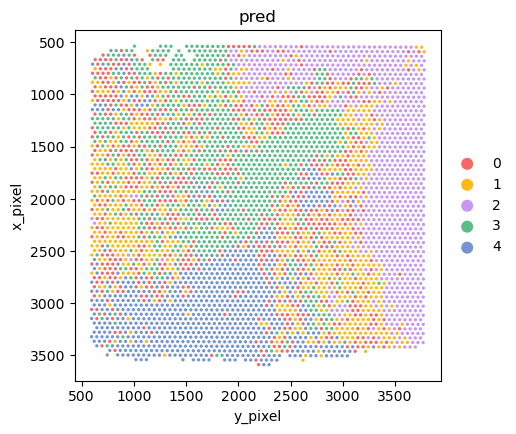

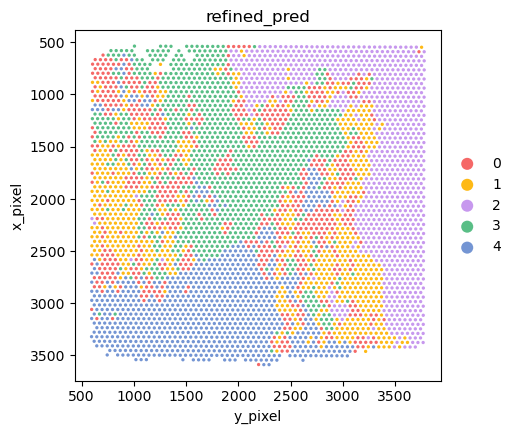

In [94]:
#adata.obs should contain two columns for x_pixel and y_pixel
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

plt.show()

#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

plt.show()